In [1]:
#python3
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
np.random.seed(seed=2222)

In [3]:
data = pd.read_json("../data/train.json")
test = pd.read_json("../data/test.json")

In [4]:
data['band_1'] = data['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x: np.array(x).reshape(75, 75))
test['band_1'] = test['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x: np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

In [5]:
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[[-27.878361, -27.15416, -28.668615, -29.53797...","[[-27.154118, -29.537888, -31.0306, -32.190483...",dfd5f913,43.9239,0
1,"[[-12.242375, -14.920305, -14.920363, -12.6663...","[[-31.506321, -27.984554, -26.645678, -23.7676...",e25388fd,38.1562,0
2,"[[-24.603676, -24.603714, -24.871029, -23.1527...","[[-24.870956, -24.092632, -20.653963, -19.4110...",58b2aaa0,45.2859,1
3,"[[-22.454607, -23.082819, -23.998013, -23.9980...","[[-27.889421, -27.519794, -27.165262, -29.1035...",4cfc3a18,43.8306,0
4,"[[-26.006956, -23.164886, -23.164886, -26.8911...","[[-27.206915, -30.259186, -30.259186, -23.1649...",271f93f4,35.6256,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1471 non-null float64
is_iceberg    1604 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 75.2+ KB


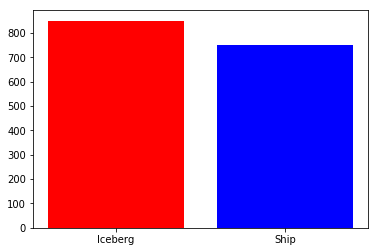

In [7]:
iceberg, ship = plt.bar((0,1), (data[data['is_iceberg']==False].shape[0], data[data['is_iceberg']==True].shape[0]))
iceberg.set_facecolor('r')
ship.set_facecolor('b')
plt.xticks((0,1), ['Iceberg', 'Ship'])
plt.show()

In [8]:
def plot_sample(is_iceberg):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    sample = data[data['is_iceberg']==is_iceberg].sample()
    band_1 = sample['band_1'].item()
    band_2 = sample['band_2'].item()
    ax1.imshow(band_1)
    ax1.set_title('band_1')    
    ax2.imshow(band_2)
    ax2.set_title('band_2')
    ax3.hist(band_1.ravel(), bins=256)
    ax3.set_title('hist_1')
    ax3.set_xlabel('db')
    ax4.hist(band_2.ravel(), bins=256)
    ax4.set_title('hist_4')
    ax4.set_xlabel('db')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle('Iceberg sample' if is_iceberg else 'Ship sample')
    plt.show()

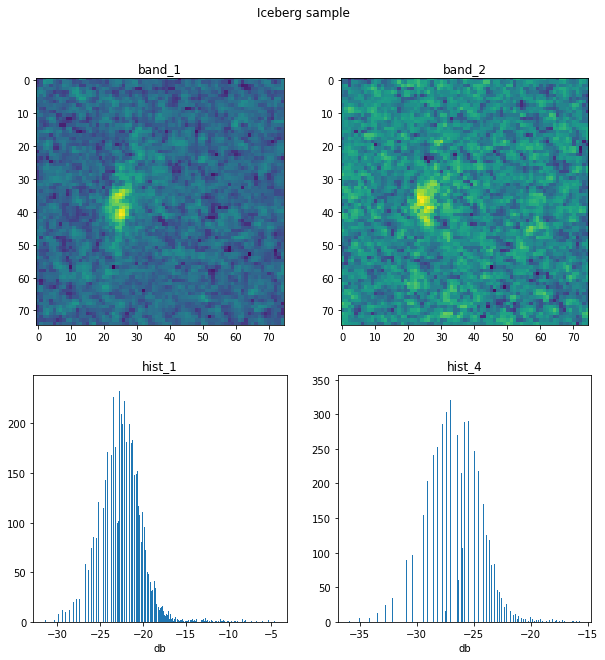

In [9]:
plot_sample(True)
# sample = data[data['is_iceberg']==True].sample()
# sample['band_1'].item()

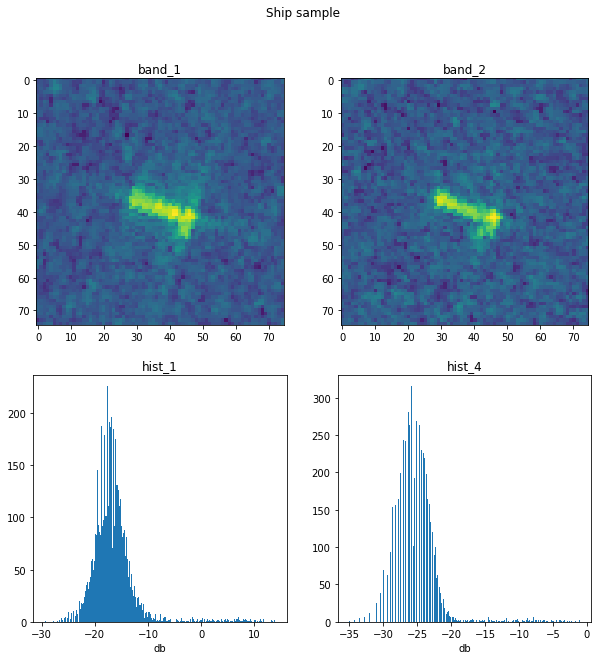

In [10]:
plot_sample(False)

In [11]:
def hist_comparison():
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    iceberg = data[data['is_iceberg']==True].sample()
    ship = data[data['is_iceberg']==False].sample()
    # band_1
    ship_band_1 = ship['band_1'].item()
    iceberg_band_1 = iceberg['band_1'].item()
    ax1.hist(ship_band_1.ravel(), bins=256, label='ship')
    ax1.hist(iceberg_band_1.ravel(), bins=256, label='iceberg')
    ax1.set_title('band 1 hist')
    ax1.set_xlabel('db')
    ax1.legend()    
    # band_2
    ship_band_2 = ship['band_2'].item()
    iceberg_band_2 = iceberg['band_2'].item()
    ax2.hist(ship_band_2.ravel(), bins=256, label='ship')
    ax2.hist(iceberg_band_2.ravel(), bins=256, label='iceberg')
    ax2.set_title('band 2 hist')
    ax2.set_xlabel('db')
    ax2.legend()
    
    fig.set_figheight(10)
    fig.set_figwidth(10)
    plt.suptitle('sample comparison')
    plt.show()

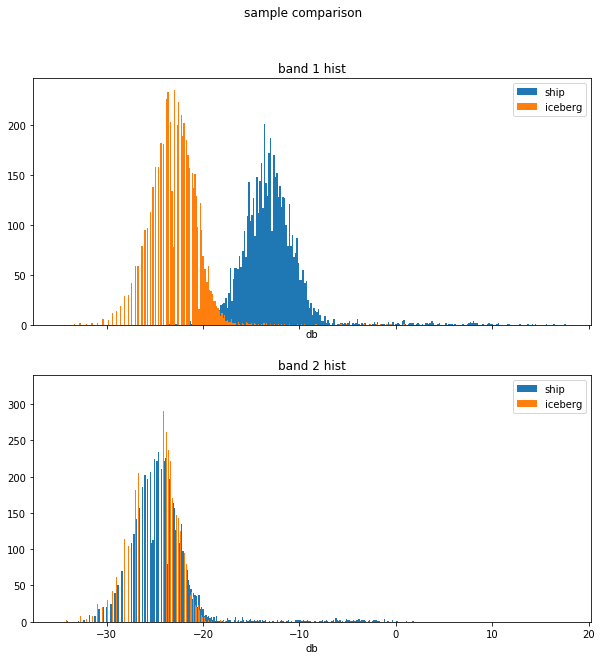

In [13]:
hist_comparison()

# (n, 2, 75, 75)

In [31]:
band_1_tensor = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_tensor = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
data_tensor = np.stack([band_1_tensor, band_2_tensor], axis=1)

test_band_1_tensor = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
test_band_2_tensor = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
test_tensor = np.stack([test_band_1_tensor, test_band_2_tensor], axis=1)

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import torch.optim as optim

In [16]:
# Building datasets

random_indices = np.random.permutation(data.shape[0])
training_indices, validation_indices = random_indices[:1200],random_indices[1200:]

training_tensors = torch.from_numpy(data_tensor[training_indices]).float()
training_labels = np.array([b for b in data['is_iceberg'][training_indices]])
training_targets = torch.from_numpy(training_labels).long()

training_dataset = TensorDataset(training_tensors, training_targets)
validation_tensors = torch.from_numpy(data_tensor[validation_indices]).float()
validation_labels = np.array([b for b in data['is_iceberg'][validation_indices]])
validation_targets = torch.from_numpy(validation_labels).long()

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #self.batch = nn.BatrchNorm2d(2)
        self.cuda = False
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64* 18 * 18, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, inputs):
        x = self.pool(F.relu(self.conv1(inputs)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [25]:
import copy
class Validator(object):
    def __init__(self, validation_tensors, validation_targets):
        self.best_model = None
        self.best_loss = None
        self.inputs = validation_tensors
        self.targets = validation_targets
        
    def validate(self, model):
        distribution = model(self.inputs)
        loss = criterion(distribution, self.targets).data[0]
        _, preds = torch.max(distribution.data, 1)
        correct_predictions = torch.sum(preds == self.targets.data)        
        if self.best_model is None or loss < self.best_loss:
#            print("best result so far")
            self.best_loss = loss
            self.best_model = copy.deepcopy(model).cpu()
        print("validation loss: {}, accuracy: {}".format(loss, correct_predictions/404))
        return loss

In [26]:
def visualize_losses(epoch_losses, valid_losses):
    x = np.arange(1, len(epoch_losses) + 1)
    plt.plot(x, epoch_losses, c='b', label='Training')
    plt.plot(x, valid_losses, c='r', label='Validation')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
#    plt.title('Training loss with {} learning rate and {} layer sizes'.format(learning_rate, layers))
    plt.savefig("loss_results.png")
    plt.show()

In [27]:
def fit(epoch, batch_size, validator, learning_rate=0.01, model=CNN()):

    optimizer = optim.Adam(net.parameters(), lr = learning_rate)

    
    train_loader = DataLoader(
                dataset=training_dataset,
                batch_size= batch_size,
                shuffle=True
            )
    
    # for visualizing training
    training_x = Variable(training_tensors)
    training_y = Variable(training_targets)
    train_losses = []
    valid_losses = []

    for epoch in range(epoch):
        running_loss = 0.
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            inputs, targets = Variable(inputs), Variable(targets)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

                

        # for visualizing data        
        distributions = net(training_x)
        loss = criterion(distributions, training_y)
        _, preds = torch.max(distributions.data, 1)
        correct_predictions = torch.sum(preds == training_y.data)
        train_losses.append(loss.data[0])
    
        print("epoch: {}, loss: {}, accuracy: {}".format(epoch, loss.data[0], correct_predictions/1200))

        valid_loss = validator.validate(net)
        valid_losses.append(valid_loss)
    
    
    visualize_losses(train_losses, valid_losses)

        
    print("Training Finished!")
    
    return net, validator

In [28]:
criterion = nn.CrossEntropyLoss()
validator = Validator(Variable(validation_tensors), Variable(validation_targets))

epoch: 0, loss: 0.5660794377326965, accuracy: 0.6675
validation loss: 0.6047739386558533, accuracy: 0.6658415841584159
epoch: 1, loss: 0.5410621166229248, accuracy: 0.6991666666666667
validation loss: 0.6425275802612305, accuracy: 0.6856435643564357
epoch: 2, loss: 0.5711990594863892, accuracy: 0.6425
validation loss: 0.5779529809951782, accuracy: 0.6460396039603961
epoch: 3, loss: 0.5693216919898987, accuracy: 0.6425
validation loss: 0.5710316896438599, accuracy: 0.6410891089108911
epoch: 4, loss: 0.5546703338623047, accuracy: 0.6983333333333334
validation loss: 0.7415951490402222, accuracy: 0.6584158415841584
epoch: 5, loss: 0.5480480194091797, accuracy: 0.6708333333333333
validation loss: 0.5965064167976379, accuracy: 0.6658415841584159
epoch: 6, loss: 0.5349130034446716, accuracy: 0.68
validation loss: 0.5888617634773254, accuracy: 0.6732673267326733
epoch: 7, loss: 0.536864161491394, accuracy: 0.6783333333333333
validation loss: 0.5885372161865234, accuracy: 0.6658415841584159
epo

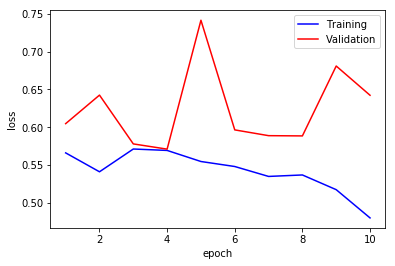

Training Finished!


In [29]:
model, validator = fit(10, 40, validator)

epoch: 0, loss: 0.5623476505279541, accuracy: 0.6891666666666667
validation loss: 0.5716696977615356, accuracy: 0.6683168316831684
epoch: 1, loss: 0.48647990822792053, accuracy: 0.7475
validation loss: 0.5305460691452026, accuracy: 0.7202970297029703
epoch: 2, loss: 0.43331247568130493, accuracy: 0.7733333333333333
validation loss: 0.5125724673271179, accuracy: 0.7103960396039604
epoch: 3, loss: 0.3587721884250641, accuracy: 0.8633333333333333
validation loss: 0.4136718809604645, accuracy: 0.8168316831683168


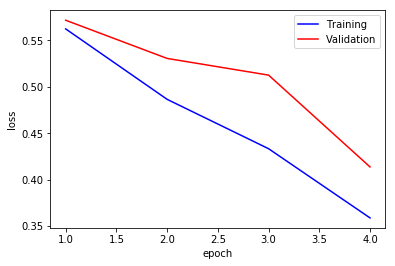

Training Finished!


In [30]:
model, validator = fit(4, 40, validator, learning_rate=0.001)

In [54]:
from IPython.core.debugger import set_trace
import os

def save_test_results(model, title='test_distribution'):
    inputs = Variable(torch.from_numpy(test_tensor).float())
    distribution = model(inputs)
    distribution = F.sigmoid(distribution).data.numpy()
    # distribution = np.exp(distribution.data.numpy())
    
    f = open('{}.csv'.format(title), 'w+')
    f.write('id,is_iceberg\n')
    for i in range(distribution.shape[0]):
        row = "{},{}\n".format(test['id'][i],distribution[i,1])
        f.write(row)
    f.close()

In [ ]:
save_test_results(validator.best_model)